In [1]:
import os
import sys
import json
import base64
import pandas as pd
import cv2
import yaml
import shutil
import albumentations as A
from matplotlib import pyplot as plt
from pathlib import Path
from ultralytics import YOLOWorld

In [27]:
all_adjectives = []
input_dir = Path("data")
with open(input_dir / "vlm.jsonl", "r") as f:
    for line in f:
        if line.strip() == "":
            continue
        
        instance = json.loads(line.strip())
        for annotation in instance["annotations"]:
            caption = annotation["caption"]
            adjectives = caption.replace(',', '').split()[:-1]
            all_adjectives.extend(adjectives)

all_adjectives = list(set(all_adjectives))
print(all_adjectives)

['black', 'grey', 'red', 'blue', 'fighter', 'and', 'orange', 'yellow', 'light', 'commercial', 'green', 'brown', 'white', 'silver', 'camouflage', 'cargo']


In [28]:
adjective_types = {
    'color': ['brown', 'grey', 'black', 'yellow', 'green', 'orange', 'silver', 'blue', 'white', 'red'],
    'craft': ['cargo', 'camouflage', 'fighter', 'commercial', 'light']
}
connectors = ['and']

In [2]:
import re
import nltk
import itertools
nltk.download('stopwords')

def clean_caption(caption):
    # This function cleans the caption by removing stopwords and punctuations.
    caption = re.sub(r'[^\w\s]', '', caption)
    word_list = [word for word in caption.split() if word.lower() not in nltk.corpus.stopwords.words('english')]
    return ' '.join(word_list)

def create_inferior_labels(caption):
    # This function generates multiple inferior versions of a label by having different permutations of reduced adjectives for the label.
    # For example, a red cargo airplane can be labeled as a red cargo airplane, a red airplane, a cargo airplane, and an airplane.
    # remove stopwords and punctuations
    caption = re.sub(r'[^\w\s]', '', caption)
    word_list = [word for word in caption.split() if word.lower() not in nltk.corpus.stopwords.words('english')]
    
    # get all possible combinations of words
    inferior_labels = []
    for i in range(len(word_list), 0, -1):
        for subset in itertools.combinations(word_list, i):
            inferior_labels.append(' '.join(subset))
    
            
    return inferior_labels

# print(create_inferior_labels('blue, yellow, and white cargo aircraft'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zedon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
input_dir = Path("data")
tables = []
counter = 0
num_train_files = int(5107 * 0.8)

yolo_root = Path("data/yolo")

image_dir = yolo_root / "images"
label_dir = yolo_root / "labels"

image_train_dir = image_dir / "train"
image_val_dir = image_dir / "val"
label_train_dir = label_dir / "train"
label_val_dir = label_dir / "val"
shutil.rmtree(image_dir, ignore_errors=True)
shutil.rmtree(label_dir, ignore_errors=True)
image_train_dir.mkdir(parents=True, exist_ok=True)
image_val_dir.mkdir(parents=True, exist_ok=True)
label_train_dir.mkdir(parents=True, exist_ok=True)
label_val_dir.mkdir(parents=True, exist_ok=True)

labels = []

tranform = A.Compose([
    A.GridDistortion(p=0.5),
    A.RandomCrop(width=640, height=640, p=0.5),
    A.ShiftScaleRotate(p=1),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=1),
    A.HueSaturationValue(p=1),
    A.AdvancedBlur(blur_limit=3, p=0.5),
    A.RandomRain(p=0.5),
    A.GaussNoise(p=1, var_limit=(10.0, 150.0), per_channel=True),
    A.ISONoise(p=1, intensity=(0.1, 0.5), color_shift=(0.01, 0.05)),
], bbox_params=A.BboxParams(format='yolo', label_fields=['captions'], min_visibility=0.2))

with open(input_dir / "vlm.jsonl", "r") as f:
    for line in f:
        if line.strip() == "":
            continue
        
        sub_dir = "train" if counter < num_train_files else "val"
        
        instance = json.loads(line.strip())
        image = cv2.imread(str(input_dir / "images" / instance["image"]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_h, img_w, _ = image.shape
        
        bboxes = []
        captions = []
        for annotation in instance["annotations"]:
            caption = clean_caption(annotation["caption"]) #'/'.join(create_inferior_labels(annotation["caption"]))
            x, y, w, h = annotation["bbox"]
            if caption not in labels:
                labels.append(caption)
            captions.append(caption)
            yolo_x = (x + w/2) / img_w
            yolo_y = (y + h/2) / img_h
            yolo_w = w / img_w
            yolo_h = h / img_h
            bboxes.append([yolo_x, yolo_y, yolo_w, yolo_h])
        transformed = tranform(image=image, captions=captions, bboxes=bboxes)
        image = transformed["image"]
        bboxes = transformed["bboxes"]
        captions = transformed["captions"]
        
        cv2.imwrite(str(image_dir / sub_dir / instance["image"]), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        
        with open(label_dir / sub_dir / instance["image"].replace("jpg", "txt"), "w") as label_file:
            for caption, bbox in zip(captions, bboxes):
                yolo_x, yolo_y, yolo_w, yolo_h = bbox
                label_file.write(f"{labels.index(caption)} {yolo_x} {yolo_y} {yolo_w} {yolo_h}\n")
                # cv2.rectangle(image, (int((yolo_x - yolo_w/2) * img_w), int((yolo_y - yolo_h/2) * img_h), int(yolo_w * img_w), int(yolo_h * img_h)), (0, 255, 0), 2)
                        
        # plt.imshow(image)
        # plt.show()
        # break
    
        counter += 1
        
# write yaml file
with open(yolo_root / "dataset_open.yaml", "w") as f:
    yaml.dump({
        "names": dict(enumerate(labels)),
        "val": "images/val",
        "train": "images/train",
        "path": os.path.abspath(yolo_root),
    }, f)

In [2]:
# download pre-trained model
model = YOLOWorld('data/yolo/vlm_yolo_album_large/weights/best.pt')


0: 384x640 1 black cargo aircraft, 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
[[     1041.5      337.39      1087.6      386.07]]
[          0]


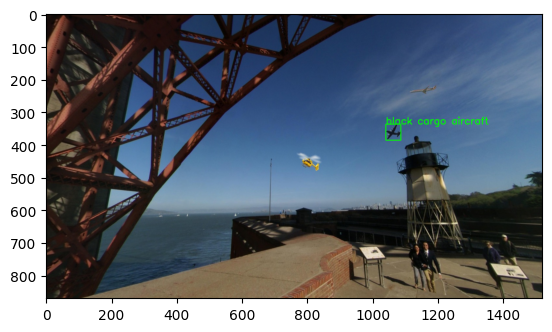

In [ ]:
# # deploy
model = YOLOWorld("data/yolo/vlm_yolo_open/weights/best.pt")
model.set_classes(["black cargo aircraft"])
image = cv2.imread("vlm/example.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = model(image, )
print(results[0].boxes.xyxy.cpu().numpy())
print(results[0].boxes.cls.cpu().numpy())
for box, cls in zip(results[0].boxes.xyxy.cpu().numpy(), results[0].boxes.cls.cpu().numpy()):
    x1, y1, x2, y2 = box
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    cv2.putText(image, model.names[int(cls)], (int(x1), int(y1)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
plt.imshow(image)
plt.show()

In [3]:
model.train(
    data="data/yolo/dataset_open.yaml",
    epochs=10,
    batch=8,
    imgsz=640,
    device=0,
    save_period=10,
    project="data/yolo",
    name="vlm_yolo_album_large",
    exist_ok=True,
    verbose=True,
    seed=0,
    patience=10,
)
    


New https://pypi.org/project/ultralytics/8.2.18 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.14  Python-3.10.11 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=data/yolo/vlm_yolo_album_large/weights/best.pt, data=data/yolo/dataset_open.yaml, epochs=10, time=None, patience=10, batch=8, imgsz=640, save=True, save_period=10, cache=False, device=0, workers=8, project=data/yolo, name=vlm_yolo_album_large, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nm

c:\Users\zedon\Documents\GitHub\til-24-overflow\.venv\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed 


train: Scanning C:\Users\zedon\Documents\GitHub\til-24-overflow\data\yolo\labels\train... 4085 images, 112 backgrounds, 0 corrupt: 100%|██████████| 4085/4085 [00:05<00:00, 710.70it/s]


train: New cache created: C:\Users\zedon\Documents\GitHub\til-24-overflow\data\yolo\labels\train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


c:\Users\zedon\Documents\GitHub\til-24-overflow\.venv\lib\site-packages\albumentations\core\composition.py:151: UserWarning: Got processor for bboxes, but no transform to process it.
  warnings.warn(f"Got processor for {proc.default_data_name}, but no transform to process it.")
val: Scanning C:\Users\zedon\Documents\GitHub\til-24-overflow\data\yolo\labels\val... 1022 images, 24 backgrounds, 0 corrupt: 100%|██████████| 1022/1022 [00:02<00:00, 451.70it/s]

val: New cache created: C:\Users\zedon\Documents\GitHub\til-24-overflow\data\yolo\labels\val.cache


Plotting labels to data\yolo\vlm_yolo_album_large\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=7.7e-05, momentum=0.9) with parameter groups 104 weight(decay=0.0), 115 weight(decay=0.0005), 121 bias(decay=0.0)


c:\Users\zedon\Documents\GitHub\til-24-overflow\.venv\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to data\yolo\vlm_yolo_album_large
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


c:\Users\zedon\Documents\GitHub\til-24-overflow\.venv\lib\site-packages\albumentations\core\composition.py:151: UserWarning: Got processor for bboxes, but no transform to process it.
  warnings.warn(f"Got processor for {proc.default_data_name}, but no transform to process it.")



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      6.35G      1.877      1.996      1.473         16        640: 100%|██████████| 511/511 [07:54<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


                   all       1022       4210      0.498      0.413      0.439      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10       6.7G      1.618      1.857      1.317         21        640: 100%|██████████| 511/511 [10:46<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:33<00:00,  1.92it/s]


                   all       1022       4210      0.534      0.425      0.456      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10       6.7G      1.549       1.78      1.282         17        640: 100%|██████████| 511/511 [11:59<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:32<00:00,  1.97it/s]


                   all       1022       4210      0.511      0.455      0.468      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10       6.4G      1.504       1.71      1.262         20        640: 100%|██████████| 511/511 [07:58<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:17<00:00,  3.59it/s]


                   all       1022       4210      0.544      0.463      0.491      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      6.55G      1.475      1.663      1.244         20        640: 100%|██████████| 511/511 [08:49<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:33<00:00,  1.94it/s]


                   all       1022       4210      0.544      0.465      0.501      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      6.55G      1.445      1.593      1.229         19        640: 100%|██████████| 511/511 [10:47<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:17<00:00,  3.59it/s]


                   all       1022       4210       0.55      0.488      0.515      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      6.55G      1.422      1.549      1.224         26        640: 100%|██████████| 511/511 [08:50<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:17<00:00,  3.64it/s]


                   all       1022       4210       0.59      0.489      0.532       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      6.54G       1.41      1.516       1.22         15        640: 100%|██████████| 511/511 [09:49<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:19<00:00,  3.27it/s]


                   all       1022       4210      0.578        0.5      0.538      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      6.48G      1.346      1.527      1.214         28        640:   1%|          | 3/511 [00:04<11:36,  1.37s/it]


KeyboardInterrupt: 

In [3]:
# test model on validation set
model.val(
    data="data/yolo/dataset_open.yaml", 
    batch=8, 
    imgsz=640, 
    device=0, 
    verbose=True,
    project="data/yolo",
    name="vlm_yolo_album_large",
    exist_ok=True,
)

Ultralytics YOLOv8.2.14  Python-3.10.11 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLOv8l-worldv2 summary (fused): 295 layers, 46807922 parameters, 0 gradients, 220.8 GFLOPs


val: Scanning C:\Users\zedon\Documents\GitHub\til-24-overflow\data\yolo\labels\val.cache... 1022 images, 20 backgrounds, 0 corrupt: 100%|██████████| 1022/1022 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  48%|████▊     | 62/128 [00:09<00:08,  7.62it/s]c:\Users\zedon\Documents\GitHub\til-24-overflow\.venv\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [00:24<00:00,  5.23it/s]


                   all       1022       4378      0.668      0.561      0.626      0.435
          grey missile       1022         32      0.359       0.42      0.292      0.202
red white blue light aircraft       1022         33      0.896      0.697      0.869      0.561
   green black missile       1022         33      0.739      0.774       0.75      0.548
  white red helicopter       1022         37      0.654      0.614      0.659      0.348
grey camouflage fighter jet       1022         37       0.27       0.27      0.261      0.201
grey white fighter plane       1022         43      0.857      0.372      0.558      0.422
     white black drone       1022         31      0.662       0.57      0.577      0.356
white black fighter jet       1022         37      0.553      0.622      0.652      0.451
         white missile       1022         43      0.538      0.256      0.347       0.23
black white commercial aircraft       1022         32      0.492      0.688      0.625      0.4

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000195D04D1B40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([      